# Fractal Analysis

Fractal analysis is a contemporary method of applying nontraditional mathematics to patterns that defy understanding with traditional Euclidean concepts. Basically, it measures complexity using fractal dimensions. The fractal dimension measures the change in "size" of a fractal set with the changing observational scale, and is not limited by integer values. There are various methods of fractal analysis; the ones used to analyse this dataset are DFA(Detrended Fluctuation Analysis), Higuchi Fractal Dimension, Katz Fractal Dimension,Hurst Exponent and Permutation Entropy.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os

In [2]:
df = pd.read_csv("D:\\terraxt intership\\intern_dataset.csv")

In [3]:
print(df.shape)
df.head()

(912000, 4)


,Time,Signal1,Signal2,Label
0,2017-08-14 11:37:49.791,33668.091913,0.856726,A
1,2017-08-14 11:37:49.801,32564.903040,0.856705,A
2,2017-08-14 11:37:49.811,31454.043305,0.856683,A
3,2017-08-14 11:37:49.821,30335.387166,0.856659,A
4,2017-08-14 11:37:49.831,29207.142938,0.856634,A


In [4]:
print(df.dtypes)
df.nunique()

Time        object
Signal1    float64
Signal2    float64
Label       object
dtype: object


Time       912000
Signal1    912000
Signal2    912000
Label           3
dtype: int64

I found various repositories, codes, packages and articles to help me understand and analyse the data better.

Sources that I found and that helped me out to clear my concepts:
1. https://en.wikipedia.org/wiki/Fractal_analysis

2. Found this site to help me clear my concept better:
https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/Fractals.htm#:~:text=Fractal%20analysis%20is%20a%20contemporary,complexity%20using%20the%20fractal%20dimension.
3. Found these kaggle codes that helped me analyse the data better:           
 https://www.kaggle.com/kerneler/starter-fractal-analysis-47dc6180-4  
 https://www.kaggle.com/prkhrr/fractal-analysis-streching-my-skillls

Since the dataset contains large numbers of data, so we're previewing only the first and last 1000 values.

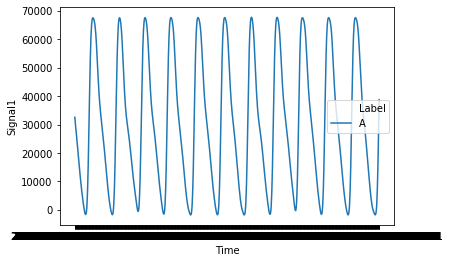

In [5]:
sns.lineplot(data = df[1:1000], x = 'Time', y = 'Signal1', hue = 'Label')

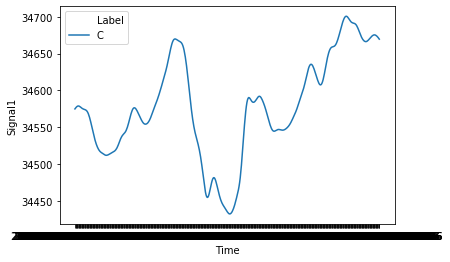

In [6]:
sns.lineplot(data = df[911500:912000], x = 'Time', y = 'Signal1', hue = 'Label')

(2.5, -0.5)

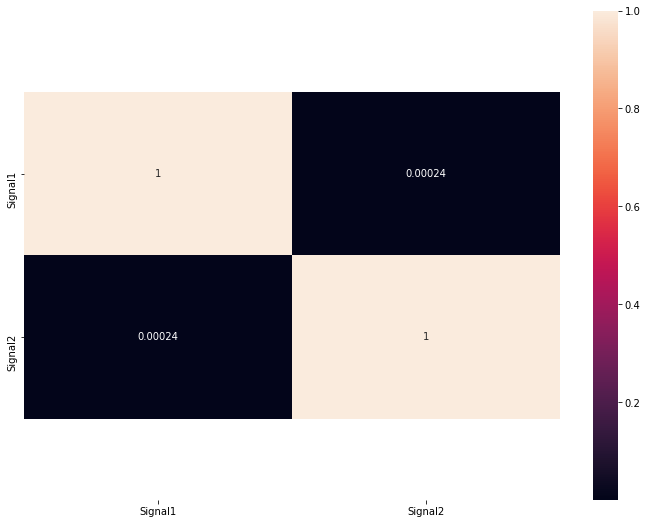

In [7]:
plt.figure(figsize=(12,9))               #correlation matrix
ax = sns.heatmap(df[1:1000].corr(),annot = True)
bottom, top = ax.get_ylim()              #fixing seaborn plotting issues
ax.set_ylim(bottom + 0.5, top - 0.5)

(2.5, -0.5)

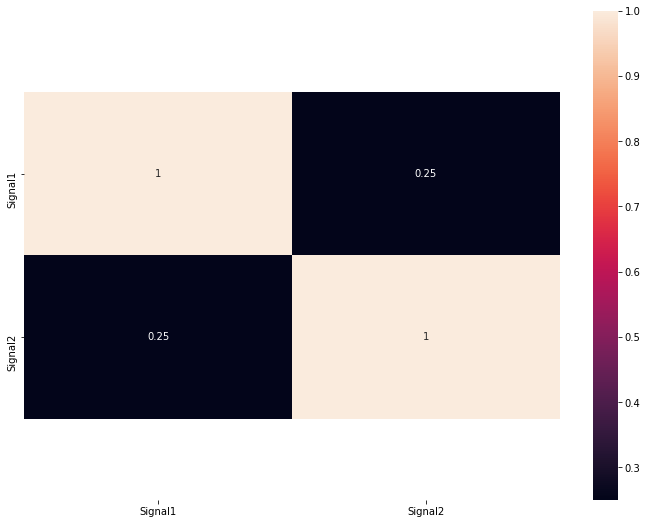

In [8]:
plt.figure(figsize=(12,9))               #correlation matrix
ax = sns.heatmap(df[911500:912000].corr(),annot = True)
bottom, top = ax.get_ylim()              #fixing seaborn plotting issues
ax.set_ylim(bottom + 0.5, top - 0.5)

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

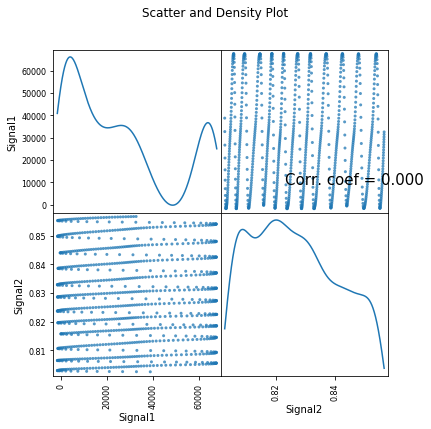

In [10]:
plotScatterMatrix(df[1:1000], 6, 15)

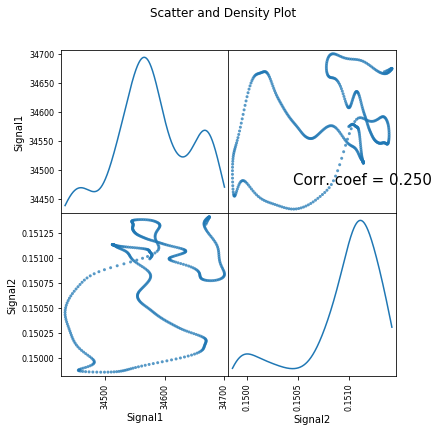

In [11]:
plotScatterMatrix(df[911500:912000], 6, 15)

As we can see from the figures above, the correlation coffecient is almost 0 in the first 1000 data and therefore can be said to  have no linear relation between the two signals. But the last 1000 data has a correlation coffecient of +0.25, therefore it might have a weak positive linear relation between the two signals.

Found this package where the DFA calculation had been done before and also plotted. (link): https://github.com/dokato/dfa/blob/master/dfa.py        
Hurst package is used: link: https://github.com/Mottl/hurst

In [12]:
# coversion function that converts the data for using in compute_Hc
# and also plots it for you. taken from the Github resource mentioned above.
def calc_rms(x, scale):
    """
    windowed Root Mean Square (RMS) with linear detrending.
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[7,12], scale_dens=0.0712, show=False):
    """
    Detrended Fluctuation Analysis - measures power law scaling coefficient
    of the given signal *x*.
    More details about the algorithm you can find e.g. here:
    Hardstone, R. et al. Detrended fluctuation analysis: A scale-free 
    view on neuronal oscillations, (2012).
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale_lim* = [5,9] : list of length 2 
        boundaries of the scale, where scale means windows among which RMS
        is calculated. Numbers from list are exponents of 2 to the power
        of X, eg. [5,9] is in fact [2**5, 2**9].
        You can think of it that if your signal is sampled with F_s = 128 Hz,
        then the lowest considered scale would be 2**5/128 = 32/128 = 0.25,
        so 250 ms.
      *scale_dens* = 0.25 : float
        density of scale divisions, eg. for 0.25 we get 2**[5, 5.25, 5.5, ... ] 
      *show* = False
        if True it shows matplotlib log-log plot.
    Returns:
    --------
      *scales* : numpy.array
        vector of scales (x axis)
      *fluct* : numpy.array
        fluctuation function values (y axis)
      *alpha* : float
        estimation of DFA exponent
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.sqrt(np.mean(calc_rms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
        print(coeff)
    return scales, fluct, coeff[0]

In [13]:
# compute_Hc will help in computing the hurst component of the data for a label A, B, C and separately
# separating the data according to the labels
df_A = df[df['Label'] == 'A']
print(len(df_A))
df_B = df[df['Label'] == 'B']
print(len(df_B))
df_C = df[df['Label'] == 'C']
print(len(df_C))

318000
312000
282000


# Label A

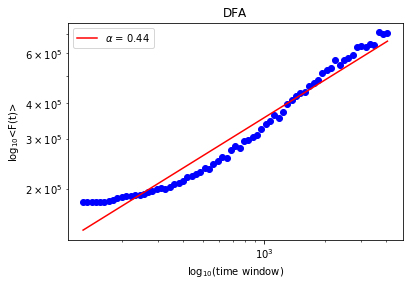

[ 0.44285088 14.02608684]
[ 128  134  141  148  155  163  172  180  189  199  209  220  231  243
  255  268  281  296  311  326  343  360  379  398  418  439  461  485
  509  535  562  591  620  652  685  720  756  794  834  877  921  968
 1017 1068 1122 1179 1239 1301 1367 1436 1509 1586 1666 1750 1839 1932
 2029 2132 2240 2353 2472 2598 2729 2867 3012 3165 3325 3493 3670 3855
 4050]
[179970.61864493 180098.09809313 179519.41098817 179192.58803803
 178886.41691419 179049.42292867 181004.44214013 182870.00494177
 184902.79934004 186959.96909253 188611.3333748  187839.15464457
 189829.86042027 189491.03608125 191569.0044925  194330.77932868
 196807.71515234 199343.04935103 200586.66113665 200191.39556653
 202358.62749216 207767.54094956 209296.81189328 213108.12229902
 219780.22931771 221877.90011859 225896.34570774 229049.06933485
 235621.62087958 234523.40411992 244937.32237774 249511.57844753
 258845.67242375 257475.67986302 273825.93030528 282256.53953364
 277730.34859439 293545.086

In [14]:
#DFA for signal-1 in Label A
series_A = np.array(df_A['Signal1'])
scales, fluct, alpha = dfa(series_A, show=1)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

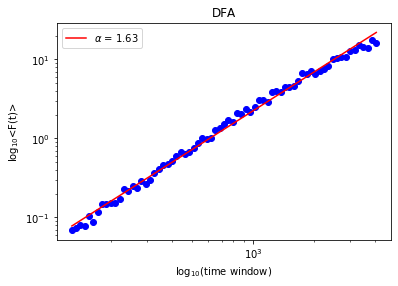

[  1.63118112 -15.09562444]
[ 128  134  141  148  155  163  172  180  189  199  209  220  231  243
  255  268  281  296  311  326  343  360  379  398  418  439  461  485
  509  535  562  591  620  652  685  720  756  794  834  877  921  968
 1017 1068 1122 1179 1239 1301 1367 1436 1509 1586 1666 1750 1839 1932
 2029 2132 2240 2353 2472 2598 2729 2867 3012 3165 3325 3493 3670 3855
 4050]
[ 0.06920572  0.0730508   0.08047342  0.07765038  0.1054538   0.08822104
  0.11623318  0.14638646  0.1466121   0.15196585  0.15246306  0.17330266
  0.22658807  0.21597044  0.24801993  0.23888033  0.28765919  0.26702284
  0.3007649   0.36858675  0.40537789  0.45643294  0.47041052  0.5182024
  0.59055748  0.68231573  0.63026773  0.665678    0.75046012  0.86567461
  1.01583158  0.97844654  1.02580861  1.27542783  1.34795549  1.5060522
  1.72029988  1.593358    2.10492173  2.04805272  2.38858304  2.1704542
  2.48226568  3.10312353  3.05578108  2.86017144  3.86220491  3.93909541
  3.85440233  4.46222946  4.5

In [15]:
#DFA for Signal-2 in label A
series_A = np.array(df['Signal2'])
scales, fluct, alpha = dfa(series_A, show=True)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

# Label B

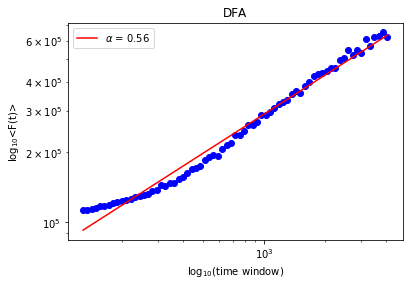

[ 0.55731827 12.59544378]
[ 128  134  141  148  155  163  172  180  189  199  209  220  231  243
  255  268  281  296  311  326  343  360  379  398  418  439  461  485
  509  535  562  591  620  652  685  720  756  794  834  877  921  968
 1017 1068 1122 1179 1239 1301 1367 1436 1509 1586 1666 1750 1839 1932
 2029 2132 2240 2353 2472 2598 2729 2867 3012 3165 3325 3493 3670 3855
 4050]
[112852.07995634 112961.61295784 114199.86575989 115336.4402356
 117113.95652397 117735.58438355 118547.27884276 120309.54583237
 121605.57988816 123372.861433   123928.15612257 125143.32365235
 127767.71806256 129498.49454981 130209.68474706 132217.76067946
 136015.10749444 137328.96694084 143659.62463468 142504.4339641
 146968.10206718 147775.46144401 152839.19469098 156385.48147995
 162655.72764007 169859.97872051 170430.88399453 173860.51359057
 184348.07493321 189768.27904561 194570.01165481 192846.68061912
 205322.81575824 213513.57459943 219479.09472547 237523.631674
 237304.79584204 244790.8852695

In [16]:
#DFA for signal-1 in label B
series_B = np.array(df_B['Signal1'])
scales, fluct, alpha = dfa(series_B, show=1)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

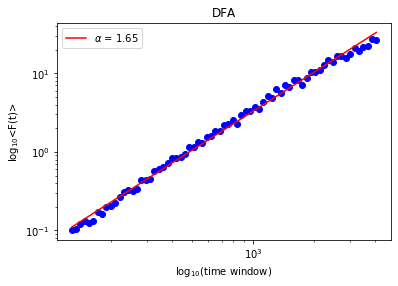

[  1.65072263 -14.73104592]
[ 128  134  141  148  155  163  172  180  189  199  209  220  231  243
  255  268  281  296  311  326  343  360  379  398  418  439  461  485
  509  535  562  591  620  652  685  720  756  794  834  877  921  968
 1017 1068 1122 1179 1239 1301 1367 1436 1509 1586 1666 1750 1839 1932
 2029 2132 2240 2353 2472 2598 2729 2867 3012 3165 3325 3493 3670 3855
 4050]
[ 0.10099712  0.10345968  0.12180163  0.13126911  0.12438878  0.13217321
  0.17284073  0.15968344  0.19822078  0.20405479  0.22440725  0.26408102
  0.30922587  0.33074827  0.31704921  0.33559436  0.44045542  0.44226836
  0.44890687  0.57613742  0.60963836  0.63304388  0.73177222  0.82548805
  0.84104999  0.85735414  0.93645833  1.16177111  1.16731983  1.34146209
  1.30222017  1.54184036  1.5929935   1.84603002  1.84216653  2.22518807
  2.26261233  2.5294063   2.29397905  2.98793196  3.33479721  3.2861842
  3.72324903  3.47040673  4.26347092  5.09315073  4.81894923  6.25782529
  5.58121122  7.03095418  6

In [17]:
# DFA for signal-2 in label B
series_B = np.array(df_B['Signal2'])
scales, fluct, alpha = dfa(series_B, show=1)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

# Label C

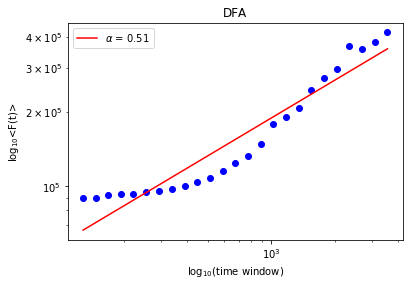

[ 0.50532547 12.48630294]
[ 128  147  168  194  222  256  294  337  388  445  512  588  675  776
  891 1024 1176 1351 1552 1782 2048 2352 2702 3104 3565]
[ 89786.43006702  89759.96735486  91963.94034232  93246.29250362
  93154.80357433  94779.14994651  95317.18404986  97852.05719801
 100396.81179798 104218.13126614 107929.01015689 115386.77678542
 124593.71703769 132677.90064745 148413.76534178 177437.69072324
 189283.66427331 207532.64414275 243587.82330001 272887.93655867
 295396.59656756 366043.86329536 356108.56542289 381857.75070487
 416481.61871772]
DFA exponent: 0.5053254725406225


In [18]:
#DFA for signal-1 in label C 
series_C = np.array(df_C['Signal1'])
scales, fluct, alpha = dfa(series_C, scale_dens=0.2 ,show=1)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

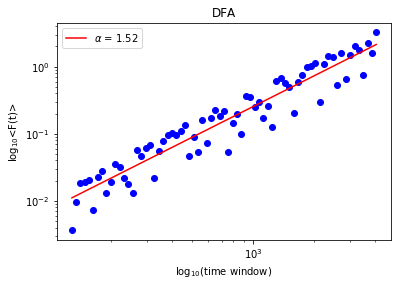

[  1.52375203 -17.1626848 ]
[ 128  134  141  148  155  163  172  180  189  199  209  220  231  243
  255  268  281  296  311  326  343  360  379  398  418  439  461  485
  509  535  562  591  620  652  685  720  756  794  834  877  921  968
 1017 1068 1122 1179 1239 1301 1367 1436 1509 1586 1666 1750 1839 1932
 2029 2132 2240 2353 2472 2598 2729 2867 3012 3165 3325 3493 3670 3855
 4050]
[0.00365648 0.00955588 0.01819214 0.01919425 0.02049096 0.00724401
 0.0225033  0.02830206 0.01299277 0.01894497 0.035461   0.03221305
 0.02156641 0.01788454 0.0131515  0.05739018 0.04644067 0.06087424
 0.06711429 0.02169205 0.05529842 0.07906073 0.09473473 0.10368202
 0.09697145 0.11003187 0.13436987 0.04644026 0.09001781 0.0531266
 0.15795286 0.07393717 0.17157329 0.22253734 0.1835236  0.22199087
 0.05420868 0.14633369 0.1999279  0.09767824 0.36773364 0.34872302
 0.25029351 0.29401278 0.17306157 0.25532164 0.12805582 0.61519805
 0.66675395 0.57879556 0.49008109 0.20262361 0.59044576 0.75174315
 0.99061

In [19]:
#DFA for signal-2 in label C
series_C = np.array(df_C['Signal2'])
scales, fluct, alpha = dfa(series_C, show=1)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

Since the data is large and takes sometime to run the code, so I only considered a certain amount of data at a time. I tried calculating the Hurst Exponent with different scales and it changes depending on the scales array. 
Here the value shows are for almost 1500 values for the graph(below) and 1800 values for the calculation of hurst exponent that sugggest 30 minutes of data, as larger the scale, better the accuracy.       
(The data is of almost 318000 seconds which is around 88.33 hours)

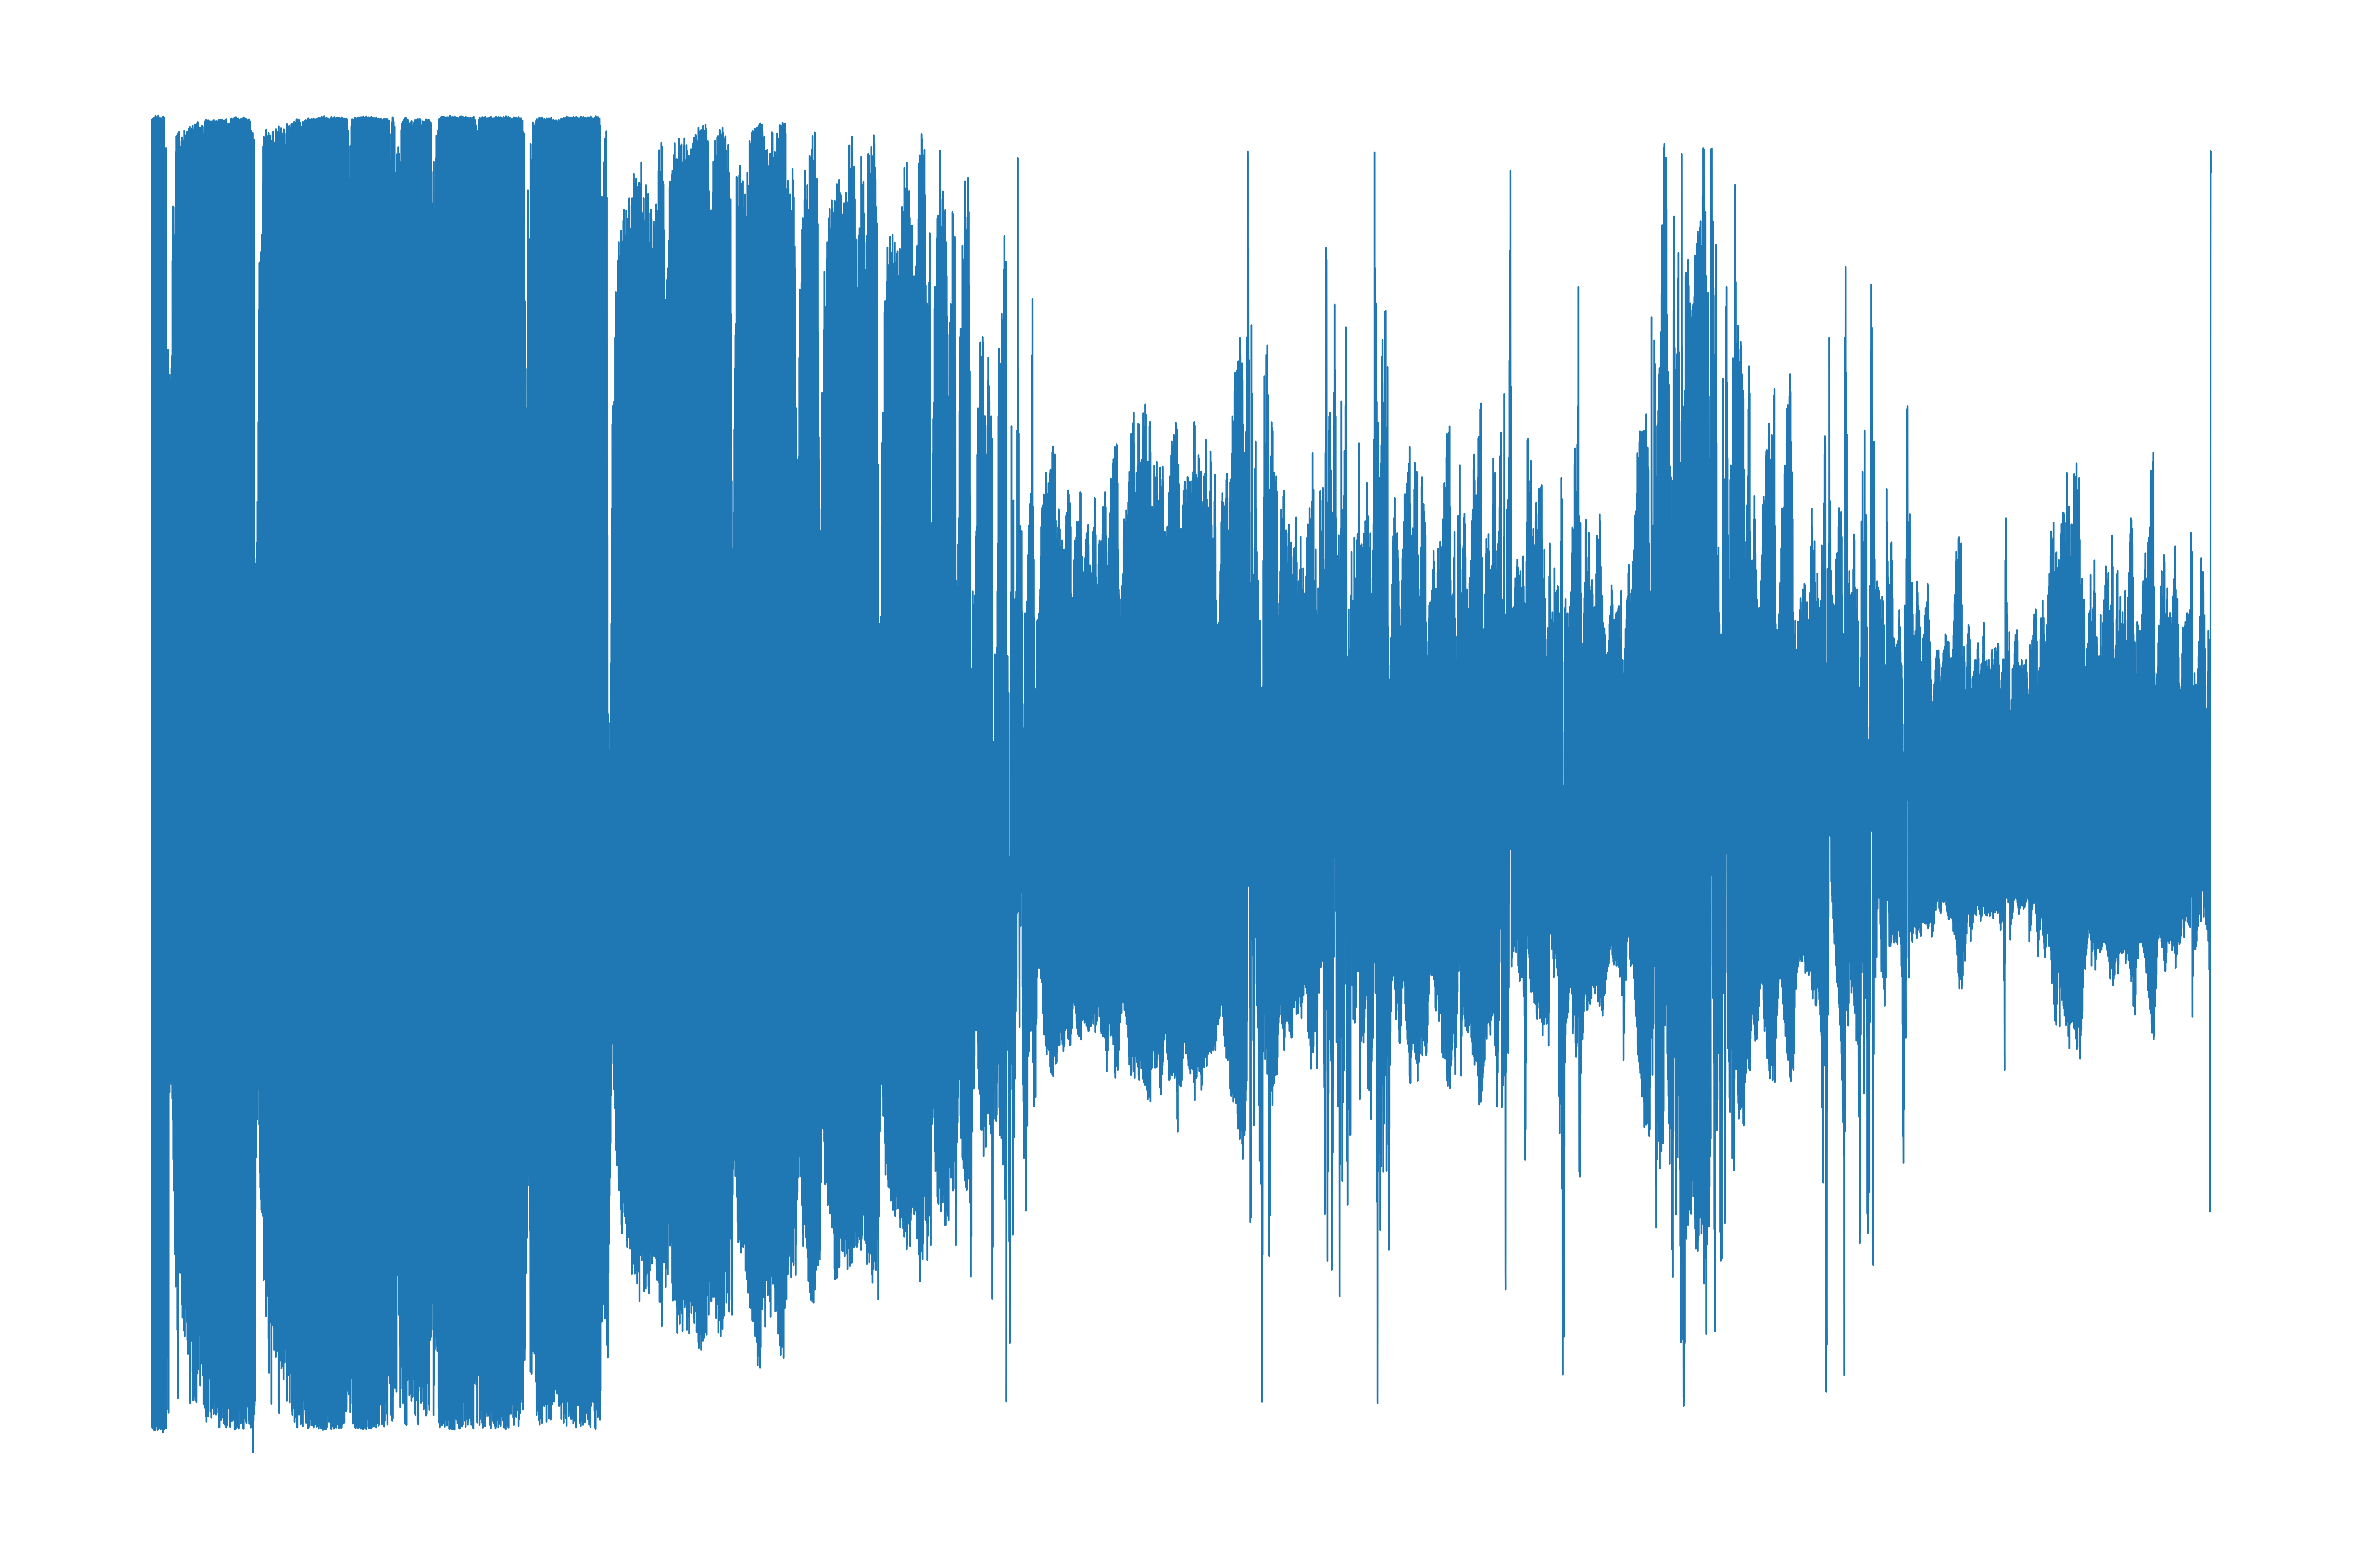

In [20]:
#plotting signal-1 of label A
plt.figure(dpi=1500)
plt.grid(b=False)
plt.axis(False)
plt.plot(np.array(df_A['Signal1']), linewidth = 0.25)
plt.show()

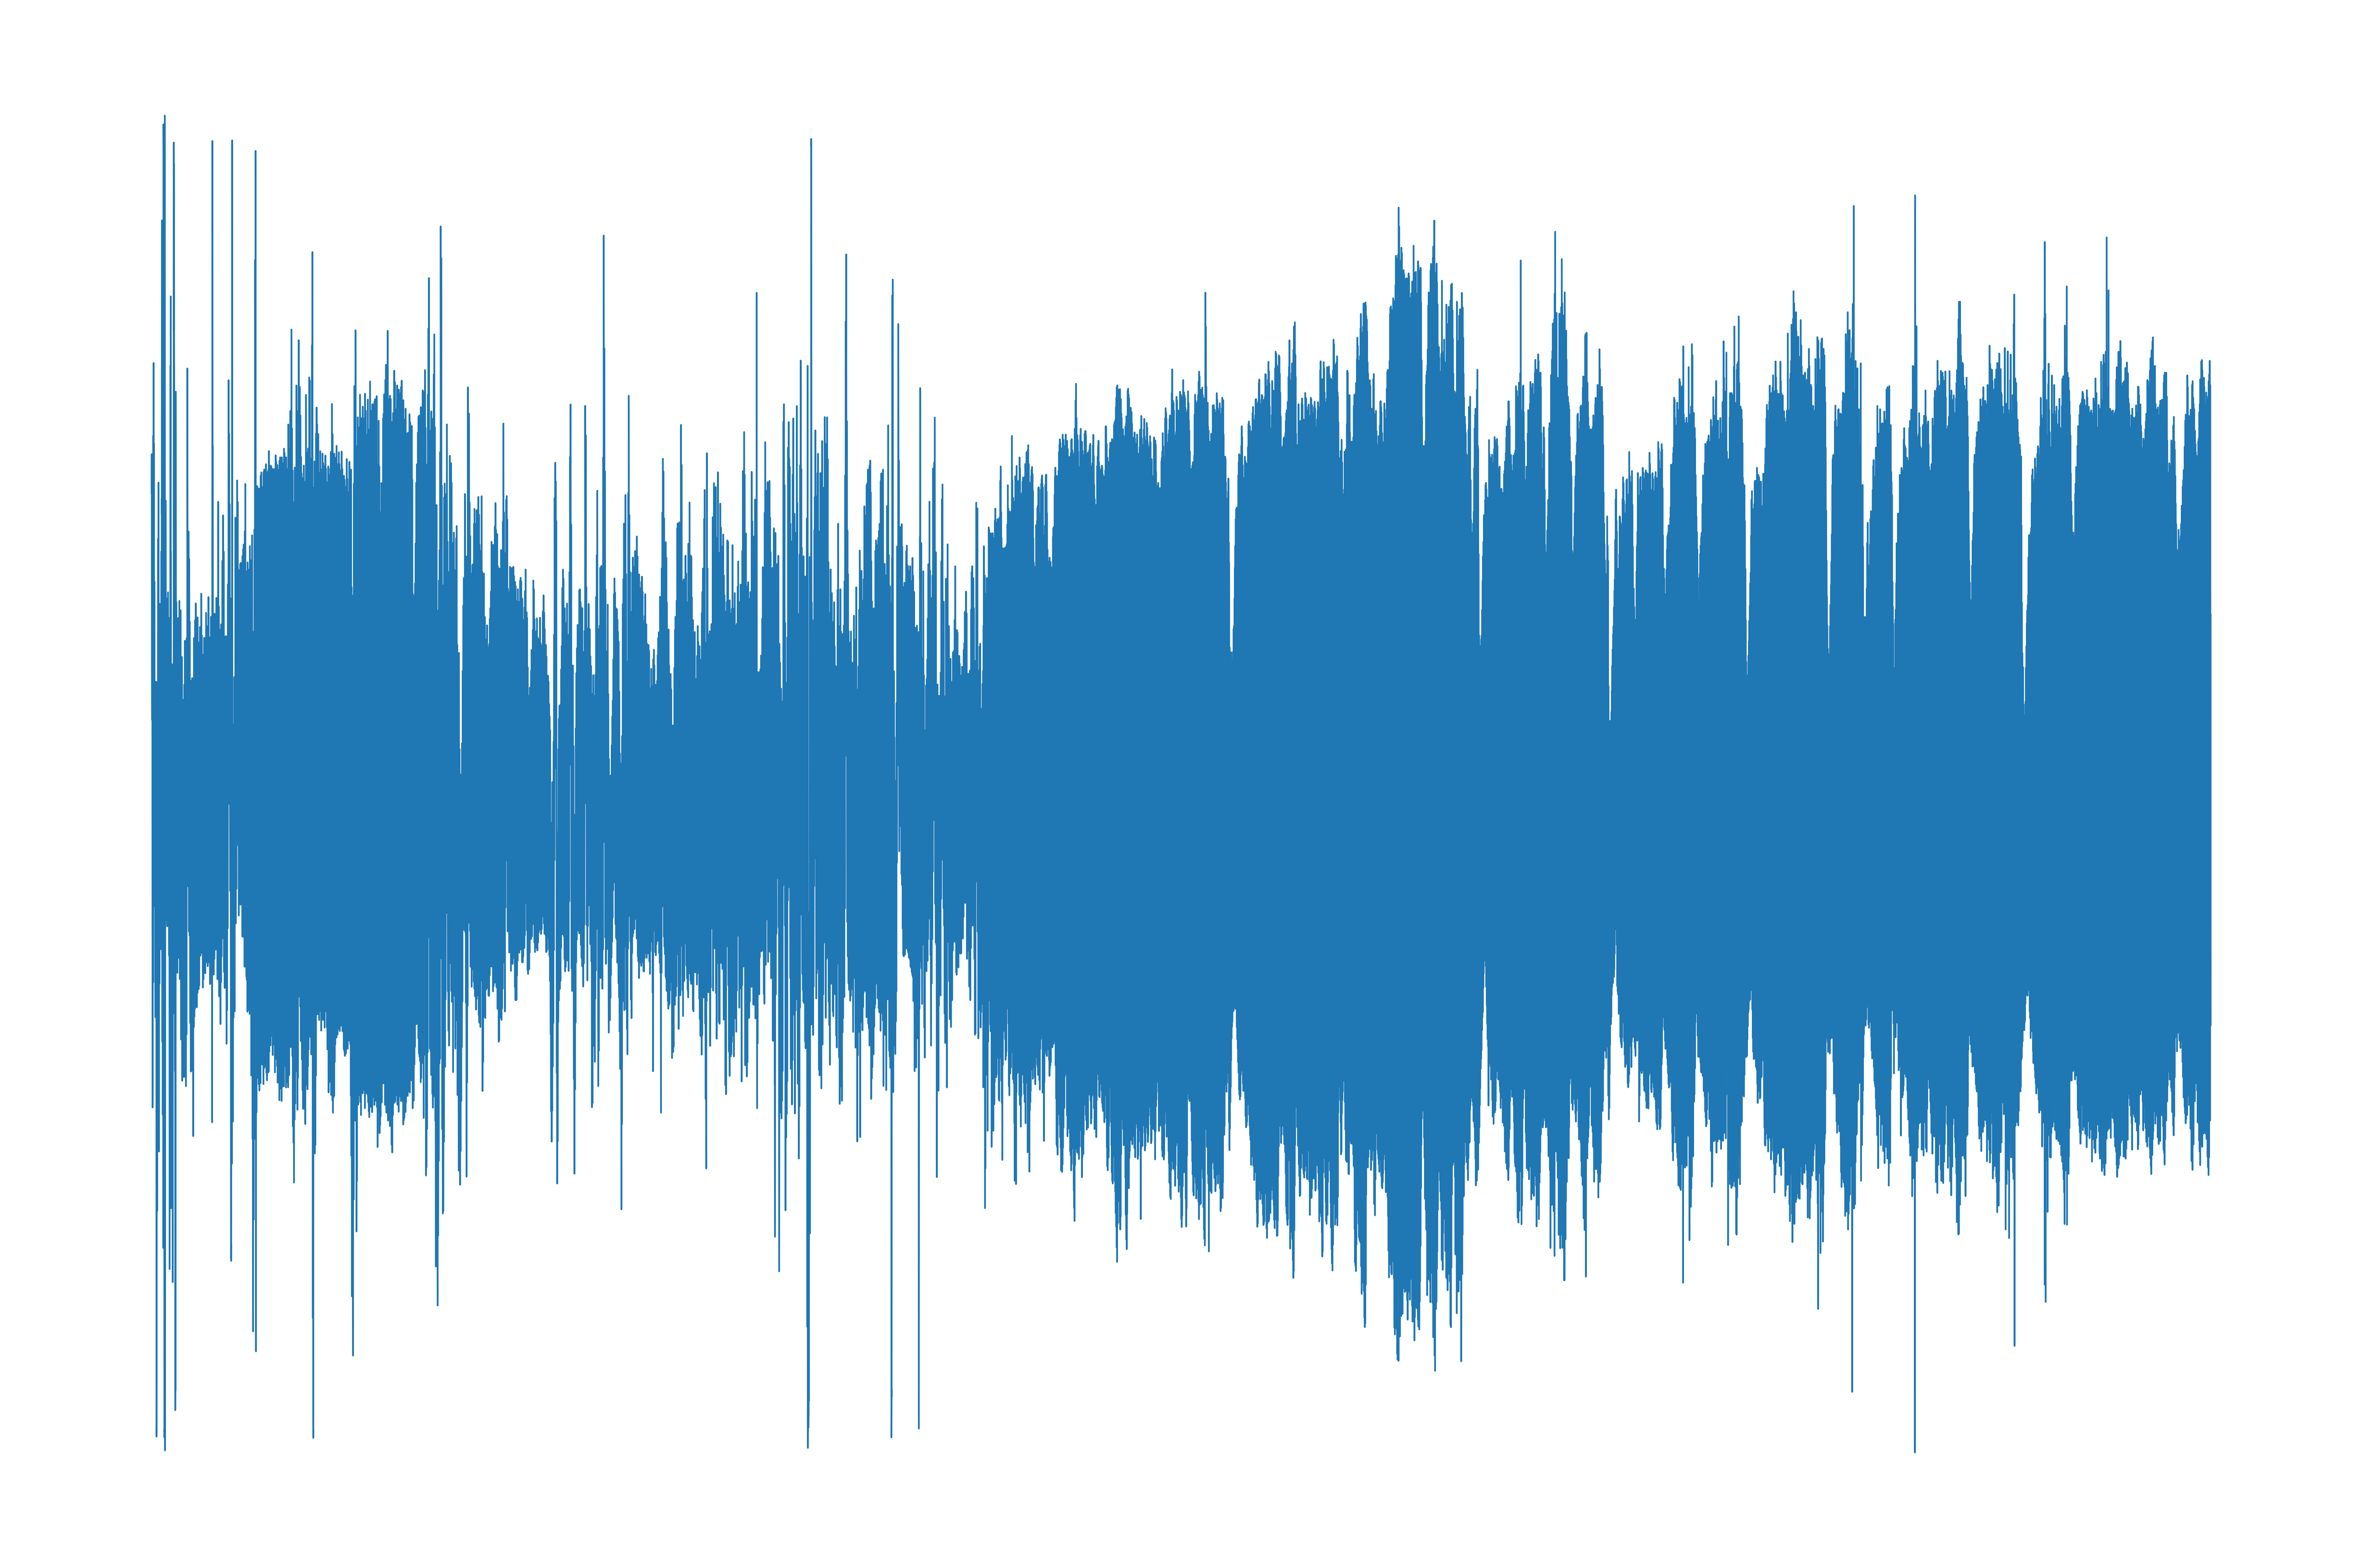

In [21]:
#plotting signal-1 of label B
plt.figure(dpi=1500)
plt.grid(b=False)
plt.axis(False)
plt.plot(np.array(df_B['Signal1']), linewidth = 0.25)
plt.show()

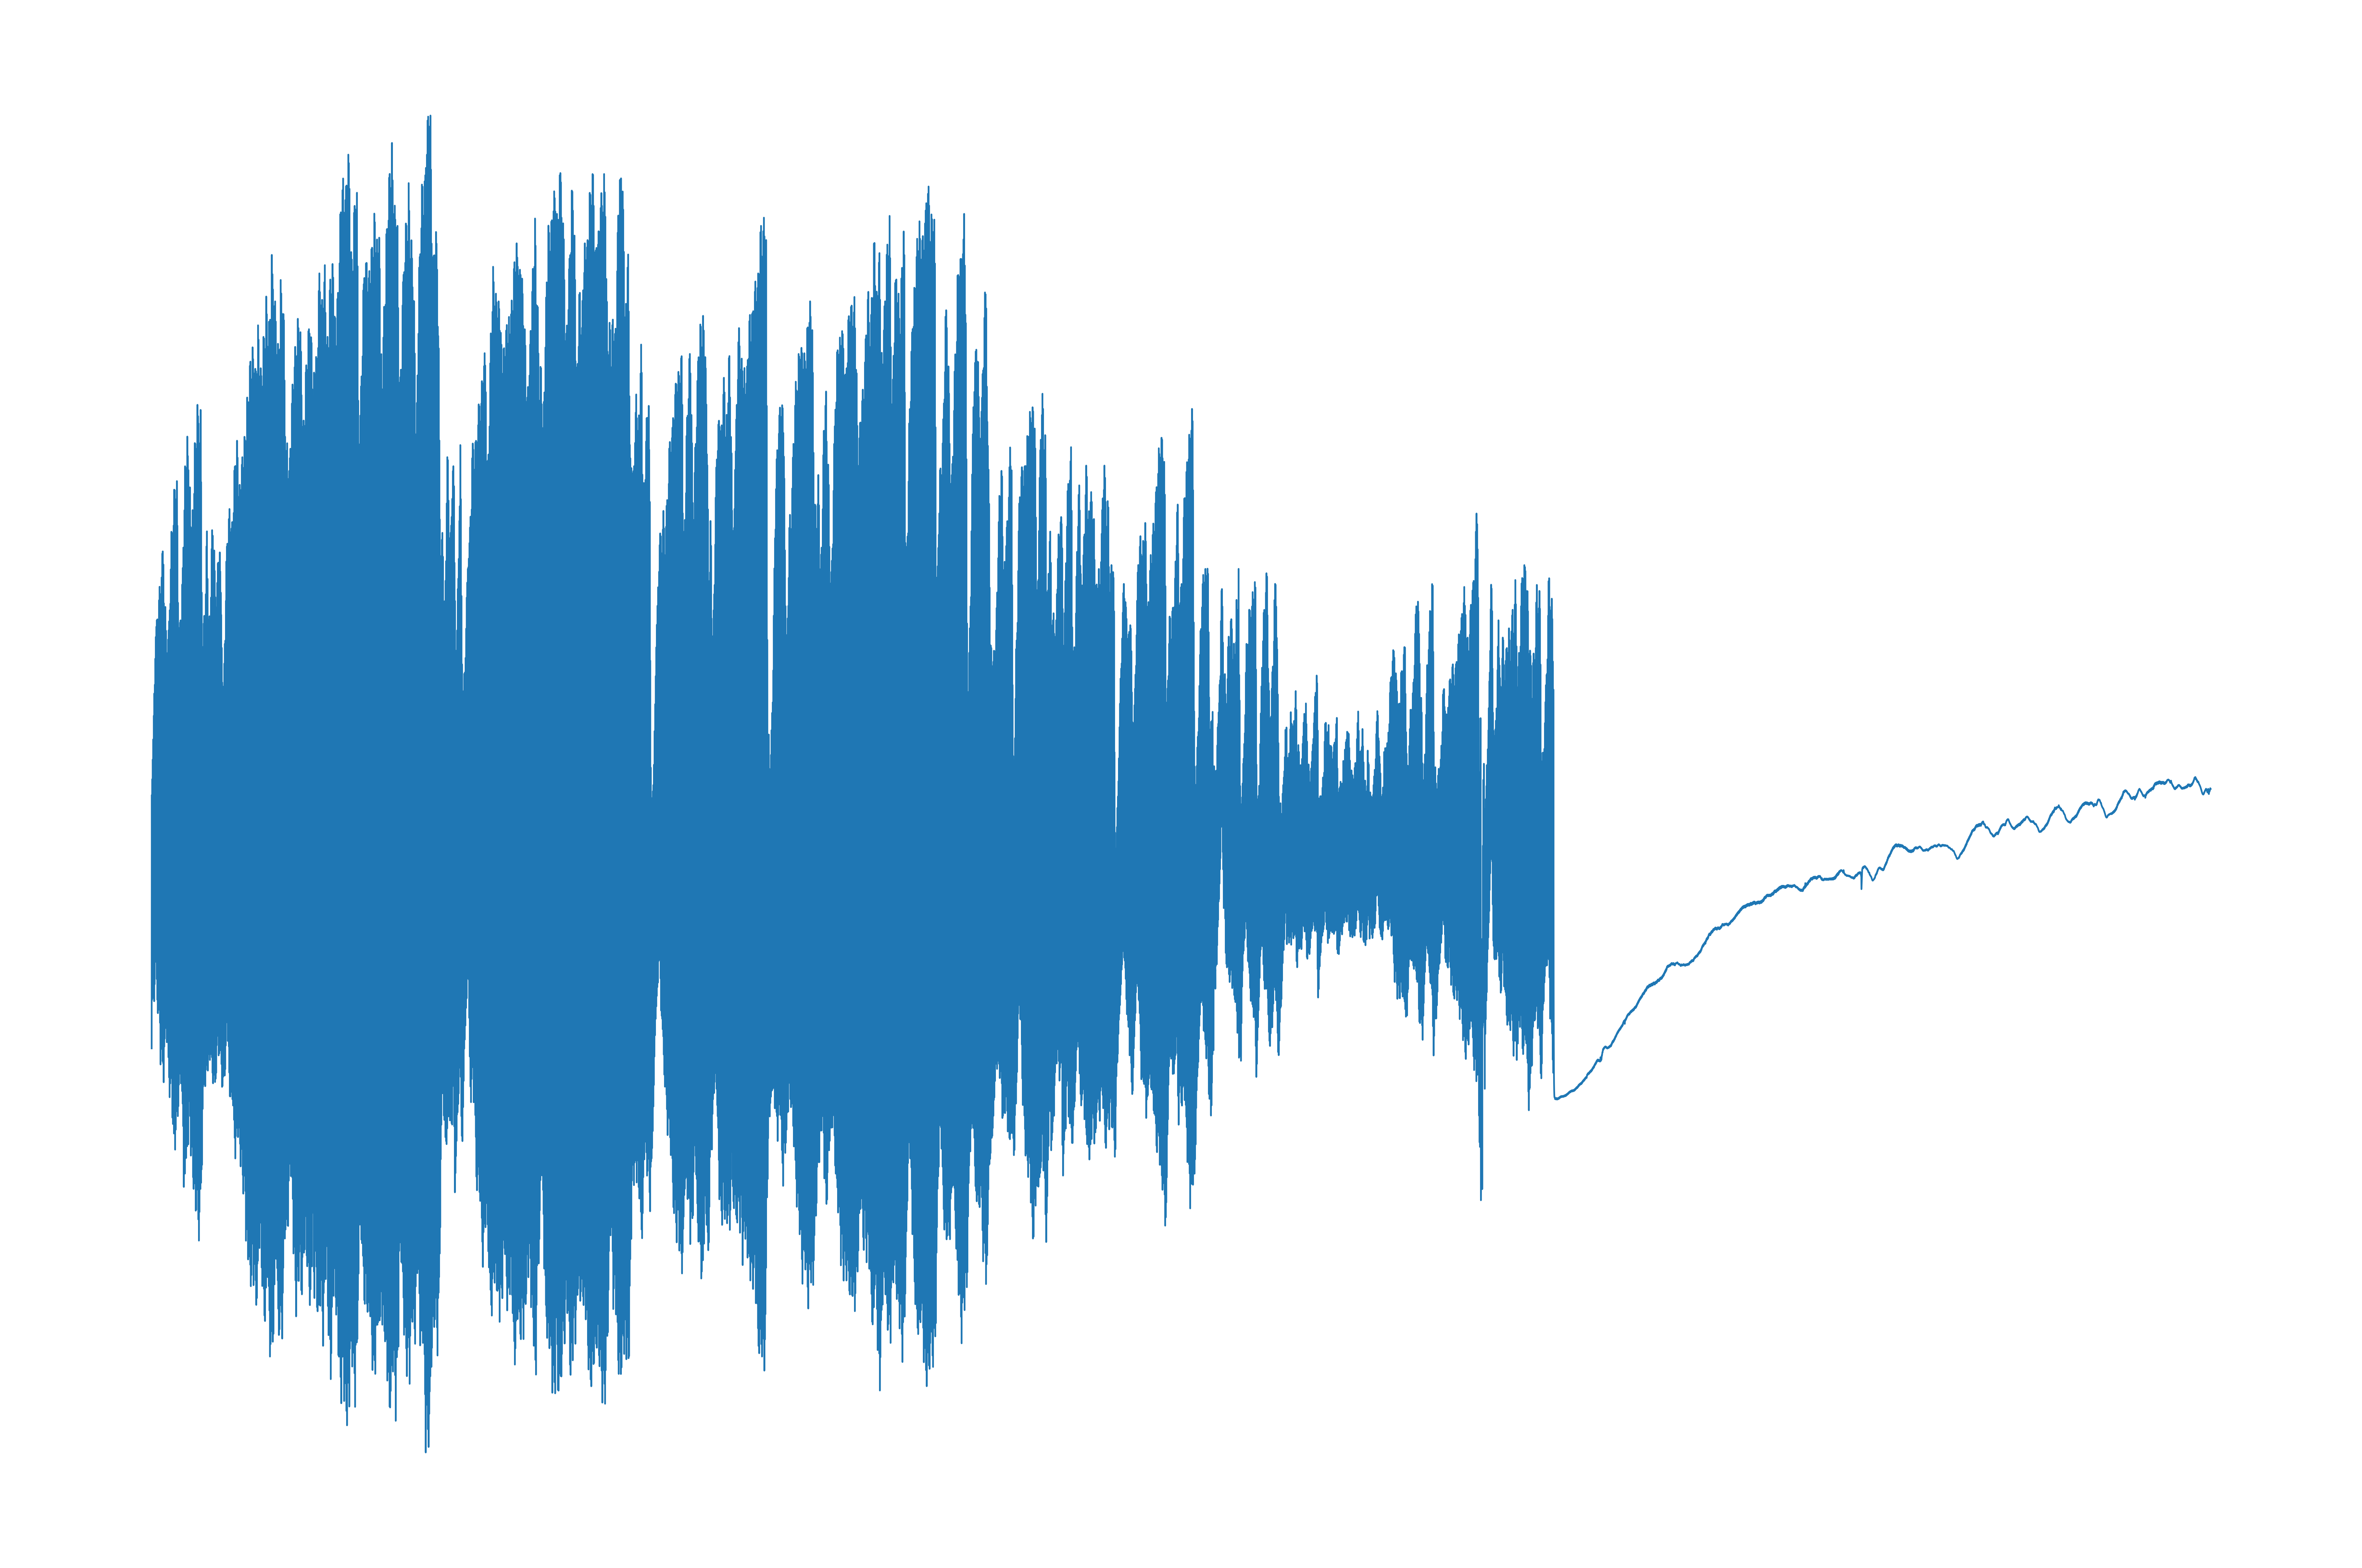

In [22]:
#plotting signal-1 of label C
plt.figure(dpi=1500)
plt.grid(b=False)
plt.axis(False)
plt.plot(np.array(df_C['Signal1']), linewidth = 0.25)
plt.show()

### Hurst Exponent for the various labels for signal-1 are:
#### Label A: 0.442
#### Label B: 0.557
#### Label C: 0.505
#### I changed the scale array a couple of times and for some scales the hurst exponent of Signal-1 of label A was more than 0.5 and of label C became less than 0.5.

#### The Hurst exponent more than 0.5 suggests persistent behaviour, less than 0.5 suggests synthetic data(unnatural), or anti persistent. If a natural looking data(coast line, heartbeat, numpy random walk) is taken then the Hurst exponent will rise closer to one.(Criticality), time series which encapsulates

#### From the plots we can see that the curve for label B does look persistent; label A does look unnatural; and the tail at C suggest higher order trend.

#### From all the above analysis we can see that Signal 2 of all the labels is unfit for DFA and therefore Box fitting method might be better.

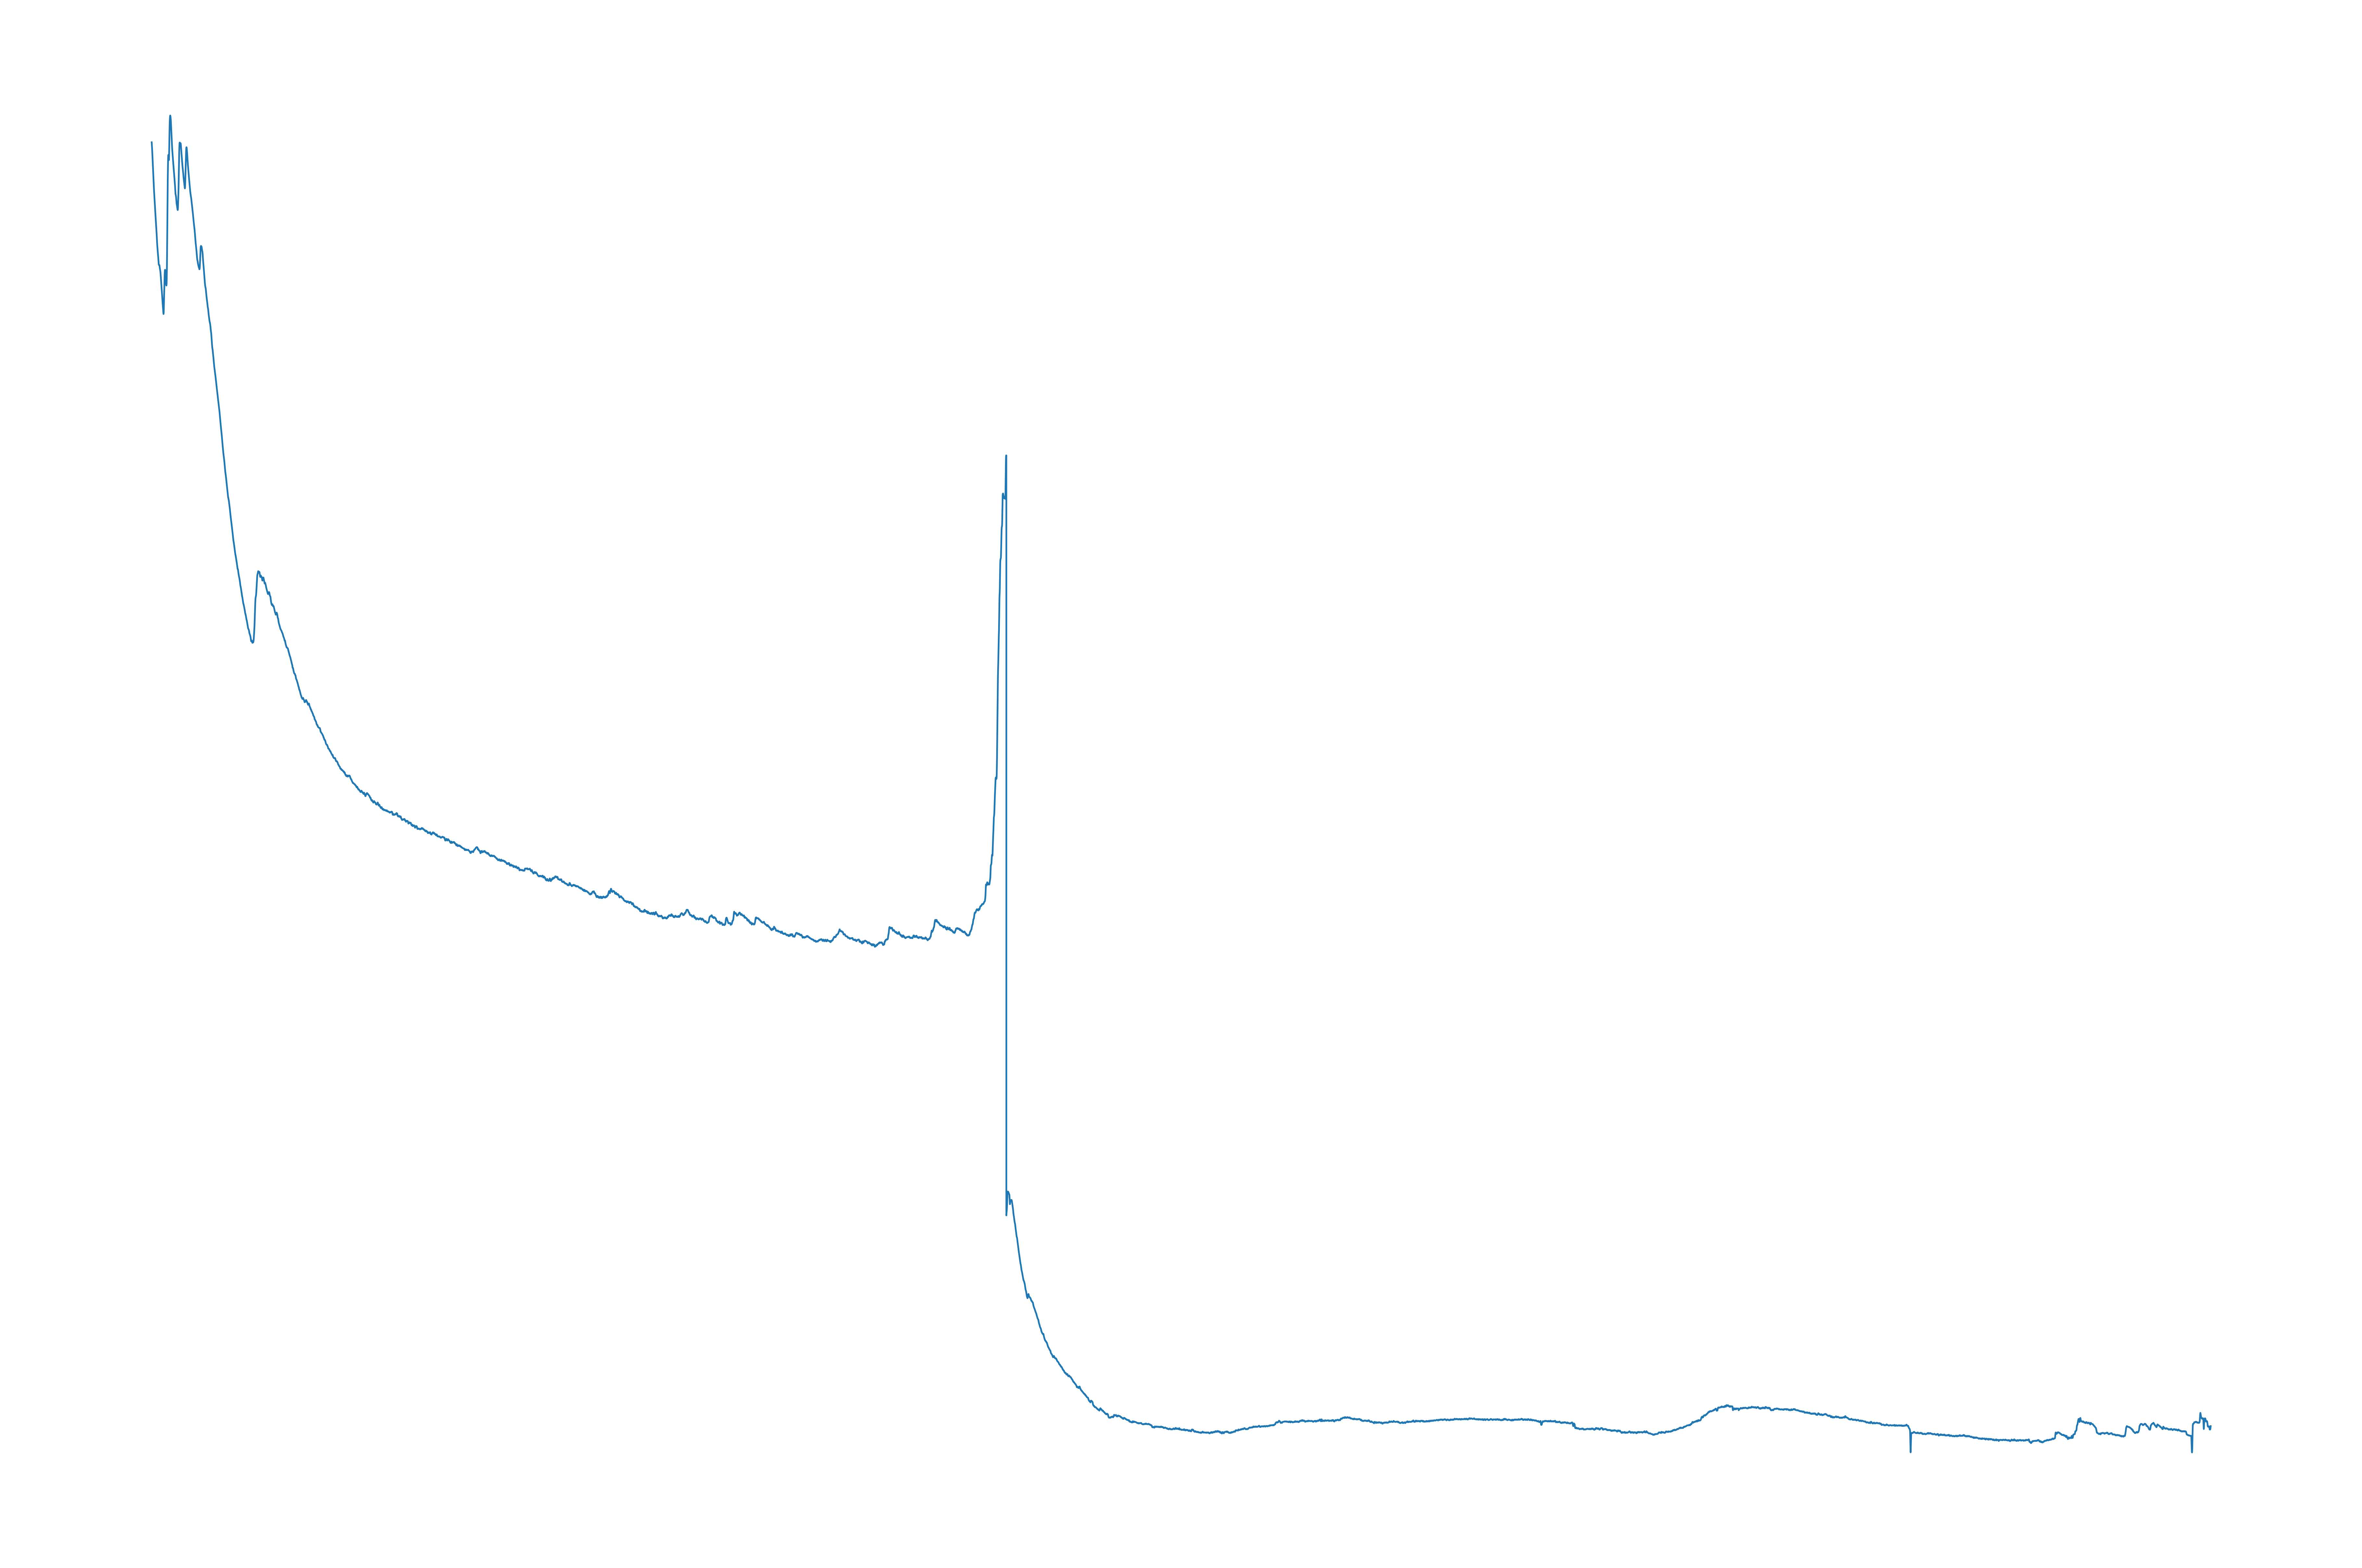

In [31]:
#plotting signal-2 of label A
plt.figure(dpi = 1500)
plt.grid(b=False)
plt.axis(False)
plt.plot(np.array(df_A['Signal2']),linewidth = 0.25)
plt.savefig('A_2.png', dpi = 1200)
plt.show()

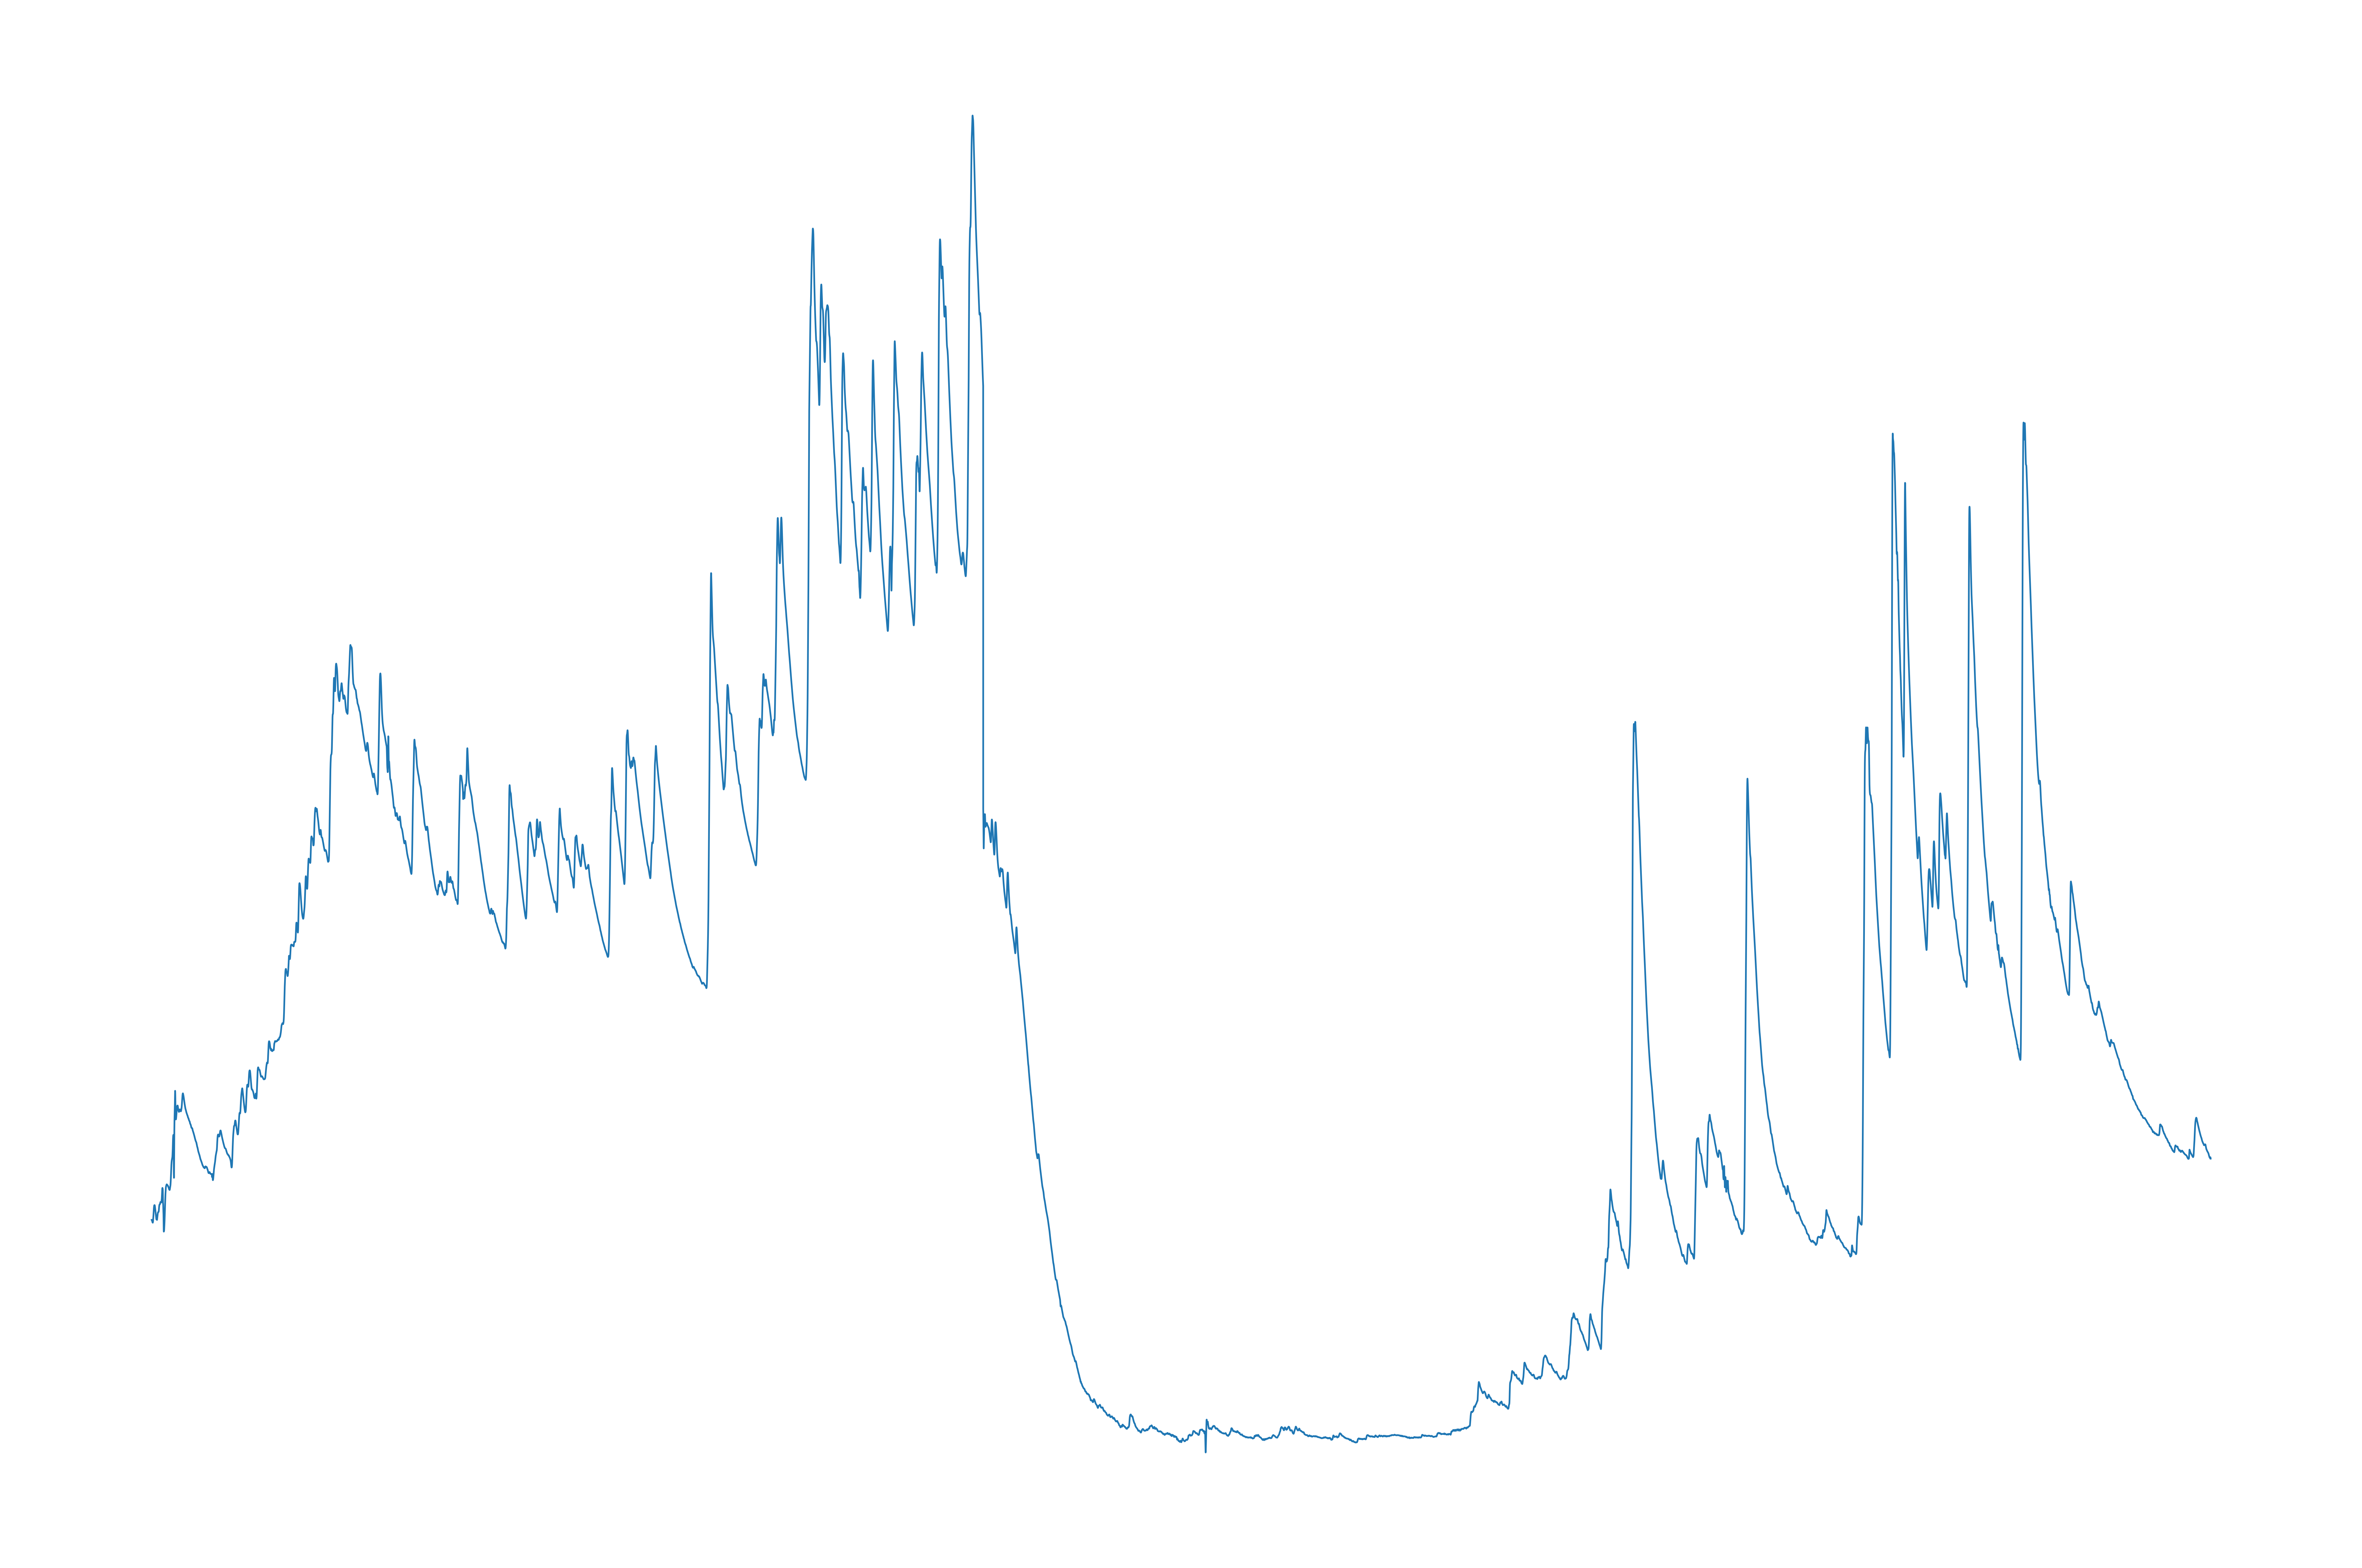

In [32]:
#plotting signal-2 of label B
plt.figure(dpi = 1500)
plt.grid(b=False)
plt.axis(False)
plt.plot(np.array(df_B['Signal2']), linewidth = 0.25)
plt.savefig('B_2.png', dpi = 1200)
plt.show()

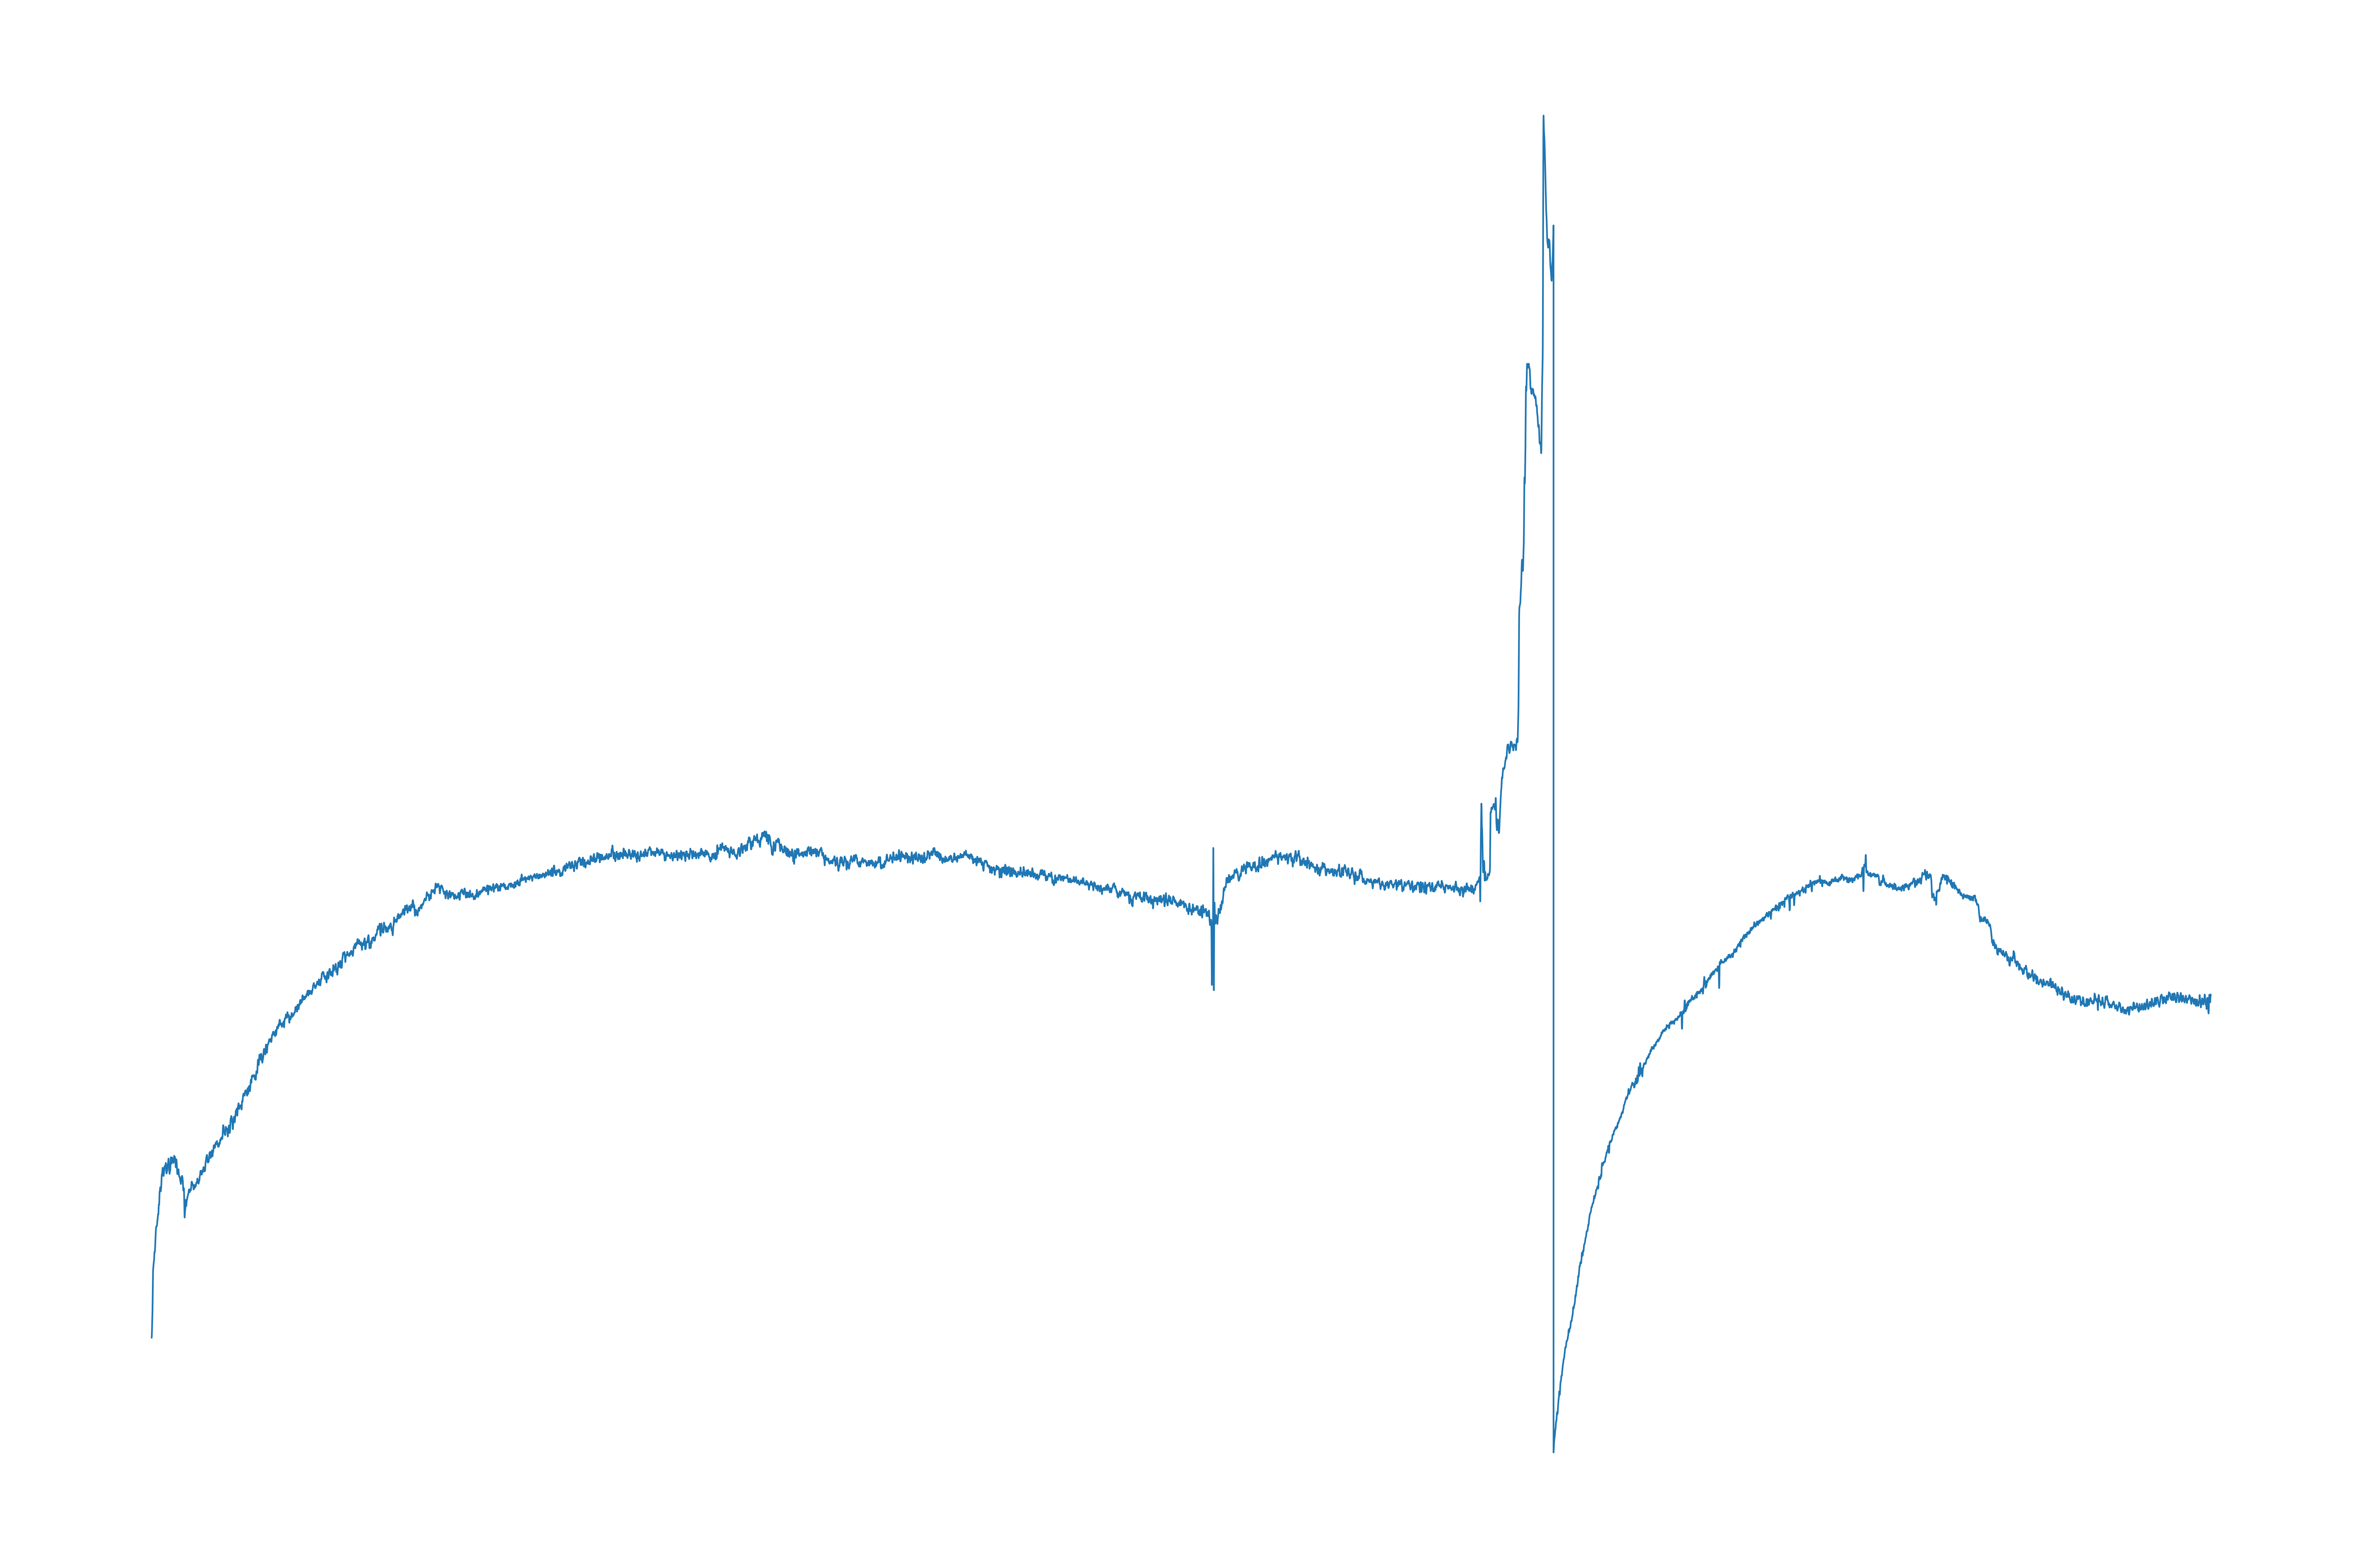

In [33]:
#plotting signal-2 of labe C
plt.figure(dpi = 1500)
plt.grid(b=False)
plt.axis(False)
plt.plot(np.array(df_C['Signal2']), linewidth = 0.25)
plt.savefig('C_2.png', dpi = 1200)
plt.show()

Compared to signal 1, signal 2 is varying very slowly over time, so much so that the DFA is not at all suitable for signal 2 , also the shape makes it apparent that some other method will be suitable.

In [34]:
def fractal_dimension(Z, threshold=0.8):
    """Returns box-counting dimension of a 2D array.
    Args:
        Z: 2D array to be analysed.
        threshold: Cutoff for converting values in Z to 1 and 0.
    Returns:
        The estimated box counting dimension.
    """

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [35]:
# > Label A, Signal 2
I = imageio.imread("A_2.png", as_gray="True")/255.0    # Import the image in greyscale
print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(I))

Minkowski–Bouligand dimension (computed):  1.1157260903800186


In [36]:
# > Label B, Signal 2
I = imageio.imread("B_2.png", as_gray="True")/255.0    # Import the image in greyscale
print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(I))

Minkowski–Bouligand dimension (computed):  1.321133463908356


In [37]:
# > Label C, Signal 2
I = imageio.imread("C_2.png", as_gray="True")/255.0
#print(np.min(I))    # Import the image in greyscale
print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(I))

Minkowski–Bouligand dimension (computed):  1.1954069894097883


### Hurst Exponent for the various labels for signal-2 are:
#### Label A: 1.115
#### Label B: 1.321
#### Label C: 1.195

#### Therefore, B is more fractal compared to A and C which can also be seen from the graphs as well.

## Katz Fractal Dimension

I found this package on github where they already define the fuction: https://github.com/ProjectBrain/brainbits/blob/master/katz.py

In [38]:
from math import log10

In [39]:
def katz(data):
    n = len(data)-1
    L = np.hypot(np.diff(data), 1).sum() # Sum of distances
    d = np.hypot(data - data[0], np.arange(len(data))).max() # furthest distance from first point
    return (log10(n)) / (log10(d/L) + log10(n))

In [40]:
series_A1 = np.array(df_A['Signal1'])
a1 = katz(series_A1)
print(a1)

2.155373488739013


In [41]:
series_A2 = np.array(df_A['Signal2'])
a2 = katz(series_A2)
print(a2)

1.000000015740541


In [42]:
series_B1 = np.array(df_B['Signal1'])
b1 = katz(series_B1)
print(b1)

2.1247126701832415


In [43]:
series_B2 = np.array(df_B['Signal2'])
b2 = katz(series_B2)
print(b2)

1.000000013993327


In [44]:
series_C1 = np.array(df_C['Signal1'])
c1 = katz(series_C1)
print(c1)

2.0044460401428017


In [45]:
series_C2 = np.array(df_C['Signal2'])
c2 = katz(series_C2)
print(c2)

1.0000000014310095


### The Katz fractal dimension value for signal 2 of all the labels is ~1 but for the signal 1 is all more than 2.

#### Few articles suggest that Katz fd value ~1 yields a straight lines while value greater the value might represent more complex curves or random behaviour. This again might be due to the fact that signal 2 vary slowly with time which can be seen from the graphs above.

## Higuchi Fractal Dimension

I found this package to calculate the higuchi fractal dimension in kaggle: https://www.kaggle.com/tarunpaparaju/ion-switching-competition-signal-eda/execution?select=sample_submission.csv

In [46]:
from math import floor
from math import log

In [47]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)
def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=8):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

In [53]:
data1 = np.array(df_A['Signal1'])
v1 = higuchi_fd(data1, kmax = 8)
print(v1)

1.0100065182740146


In [54]:
data2 = np.array(df_A['Signal2'])
v2 = higuchi_fd(data2, kmax = 8)
print(v2)

1.001243002176468


In [55]:
data3 = np.array(df_B['Signal1'])
v3 = higuchi_fd(data3, kmax = 8)
print(v3)

1.0149357270105206


In [56]:
data4 = np.array(df_B['Signal2'])
v4 = higuchi_fd(data4, kmax = 8)
print(v4)

1.0001724303635076


In [57]:
data5 = np.array(df_C['Signal1'])
v5 = higuchi_fd(data5, kmax = 8)
print(v5)

1.0168188615404243


In [58]:
data6 = np.array(df_C['Signal2'])
v6 = higuchi_fd(data6, kmax = 8)
print(v6)

1.0023136118762184


Here, it is important to note that, the Katz and Higuchi algorithms, consider the extra length of the curve as a measure of the FD while the Hurst exponent FD considers the range of the cumulative deviations in a given waveform as a measure of the FD. 

### The value of Higuchi fd for both signal 1 and 2 for all three labels is ~1, therefore it suggest all the signals to be a simple curve. I also tried calculating the values with different value for kmax and all the values turned out to be ~1.
#### But Higuchi fd is highly sensitive to noise and errors so these values might not be reliable.

## Permutation Entropy

Permutation Entropy (PE) is a robust time series tool which provides a quantification measure of the complexity of a dynamic system by capturing the order relations between values of a time series and extracting a probability distribution of the ordinal patterns.

Source of the code: https://www.kaggle.com/tarunpaparaju/ion-switching-competition-signal-eda/execution?select=sample_submission.csv

In [59]:
def _embed(x, order= 3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order= 3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [60]:
data = np.array(df_A['Signal1'])
value = perm_entropy(data)
print(value)

1.0631416327221586


In [61]:
data = np.array(df_A['Signal2'])
print(value)

1.0631416327221586


In [62]:
data = np.array(df_B['Signal1'])
value = perm_entropy(data)
print(value)

1.0926081564877728


In [63]:
data = np.array(df_B['Signal2'])
value = perm_entropy(data)
print(value)

0.8974155372958301


In [64]:
data = np.array(df_C['Signal1'])
value = perm_entropy(data)
print(value)

1.1833616417358694


In [65]:
data = np.array(df_C['Signal2'])
value = perm_entropy(data)
print(value)

1.1270238206601988


### The value of entropy increases as the order and delay increases. We calculated for different order and delay  order ranging from 3 to 18.

#### But since our data is very large, it might not give us the result correctly.


Here I found the hurst exponent to be the most helpful and easier to understand and the one to give the best result for this dataset and Katz FD to a certain extent. Since Higuchi FD and Permutation Entropy is highly sensitive to noise so it might not have yielded the best results.